# Overview

1. [Introduction to GeoPandas](#1)
2. [Datetime in Pandas](#2)
3. [Fitting Time Series](#3)


# Introduction to GeoPandas<a class="anchor" id=1></a>

GeoPandas is a python library for geospatial data in pandas DataFrames. 

    import pandas as pd
    import geopandas as gdp
    
    df  = pd.DataFrame()
    gdf = gpd.GeoDataFrame()

A GeoDataFrame can be regarded as a DataFrame plus an extra column: a GeoSeries.
GeoSeries can contain the following geometries
 
    POINTS, MULTIPOINTS     # e.g. for an address
    LINES, MULTILINES       # e.g. for a street
    POLYGONS, MULTIPOLYGONS # e.g. for city boarders
    
Additionally, the GeoSeries has an attribute for the [Coordinate Reference System](https://en.wikibooks.org/wiki/Coordinate_Reference_Systems_and_Positioning) (Mercator projection etc.), `GeoSeries.crs`. For instance `crs="EPSG:4326"` references the World Geodetic System (WGS84) which is the typical projection used for GPS data. 

There can actually be more than one GeoSeries columns within a GeoDataFrame, but always only one `geometry` is active at a time.

Geometries of geographical data are typically stored in shape files, e.g. with ending .shp. The shape file only contains the GPS-data itself, and must be accompannied by other files with ending .shx (e.g. city names corresponding to shapes), .prj with the projection, and others. Another common file type is GeoJSON, which contains all the information in *one* file.
    
See also: [geopandas User Guide](https://geopandas.org/en/stable/docs/user_guide/data_structures.html).


In [148]:
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit


#### Data directory

In [149]:
data_dir = '../data/'

## (Download and) load the shape of Spain
Downloaded from http://centrodedescargas.cnig.es/CentroDescargas/index.jsp > Mapas vectoriales y Bases Cartográficas y Topográficas:

    BCN500
    Description: Base Cartográfica Nacional a escala 1:500.000.
    SGR: ETRS89. Coordenadas geográficas longitud y latitud.
    Download entity: toda España y por capas temáticas.
    Format: shapefile (.shp)

In [3]:
# Load shape file into GeoDataFrame
spain = gpd.read_file(data_dir + "carto/BCN500_0101S_LIMITE_ADM.shp", crs="EPSG:4326") 


In [4]:
# Filter countries out, with boolean filtering, just as you would do for pandas DataFrames
# CCAA is the abbreviation for Autonomous region in Spain
spain = spain[~spain["CCAA"].isin(["SAHARA OCCIDENTAL", "ALGERIA", "PORTUGAL", 'MARRUECOS', 'MAURITANIA','FRANCIA', 'ANDORRA'])]


<Axes: >

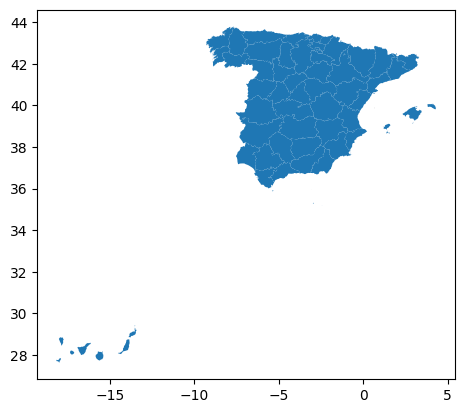

In [5]:
# plot spain
spain.plot()

<Axes: label='inset_axes'>

<Figure size 640x480 with 0 Axes>

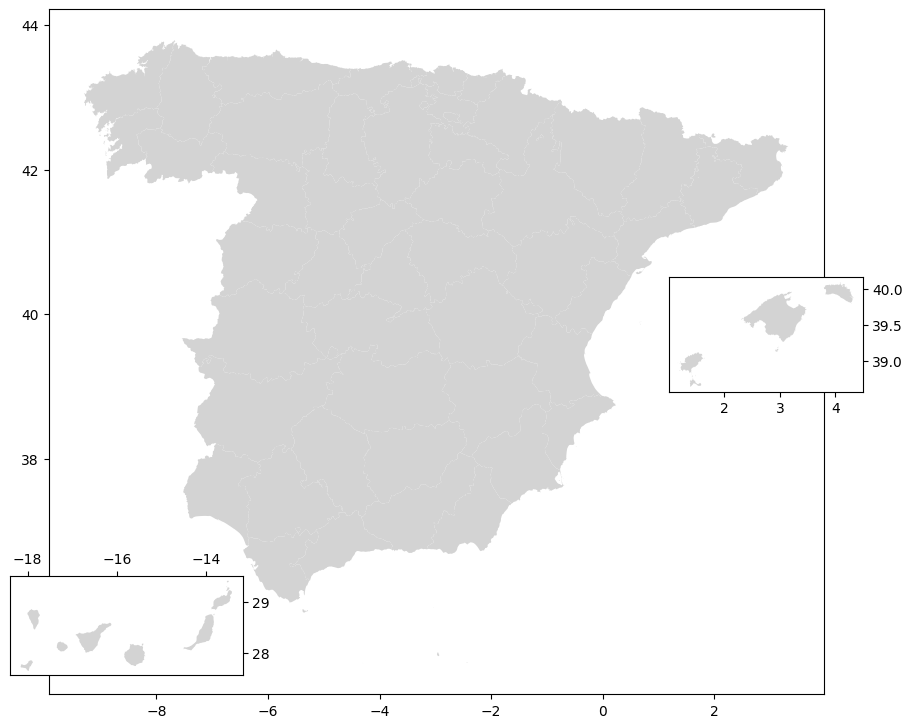

In [6]:
plt.clf()
# separate balears and canary islands, to plot them independently
spain_main_land = spain[~spain["CCAA"].isin(['Illes Balears', 'Canarias'])]
spain_canarias  = spain[spain["CCAA"].isin(['Canarias'])]
spain_baleares  = spain[spain["CCAA"].isin(['Illes Balears'])]

# create canvas where balears and canary islands are plotted independently
f, ax = plt.subplots(figsize=(10,10))
axin1 = ax.inset_axes([-0.05, -0.05, 0.3, 0.3])
axin1.xaxis.tick_top()
axin1.yaxis.tick_right()

axin2 = ax.inset_axes([0.8, 0.4, 0.25, 0.25])
axin2.yaxis.tick_right()

spain_main_land.plot(ax=ax, color="lightgray")
spain_canarias.plot(ax = axin1, color="lightgray")
spain_baleares.plot(ax = axin2, color="lightgray")

### Writing files

Just as you can load geodata with read_file, you can save geodata to files with to_file

In [7]:
# in one geojson
spain_baleares.to_file(data_dir + "carto/spain_baleares_gj.geojson", driver="GeoJSON")

# in several files including a shp file
spain_baleares.to_file(data_dir + "carto/spain_baleares.shp")

# Datetime in Pandas<a class="anchor" id=2></a>

In [117]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("analisi.transparenciacatalunya.cat", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(analisi.transparenciacatalunya.cat,
#                  MyAppToken,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("pvrz-iijx", limit=100000, where='any_entrada_sistema = 2020')

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [118]:
# drop datetimes that are nans
results_df = results_df[results_df.data_naixement_infant.notna()]
results_df.head(2)

,id_infant_jove,data_entrada_sistema,any_entrada_sistema,mes_entrada_sistema,servei_territorial_gestio,data_naixement_infant,sexe_infant,origen_infant
0,133982,2020-01-01T00:00:00.000,2020,01Gener,Barcelona ciutat,2002-12-01T00:00:00.000,Nois,Altra
1,133988,2020-01-02T00:00:00.000,2020,01Gener,Tarragona,2006-04-02T00:00:00.000,Nois,Marroc


In [119]:
# add datetime column with python datetimes
results_df["data_naixement_infant_datetime"] = pd.to_datetime(results_df.data_naixement_infant)
results_df.head(2)

,id_infant_jove,data_entrada_sistema,any_entrada_sistema,mes_entrada_sistema,servei_territorial_gestio,data_naixement_infant,sexe_infant,origen_infant,data_naixement_infant_datetime
0,133982,2020-01-01T00:00:00.000,2020,01Gener,Barcelona ciutat,2002-12-01T00:00:00.000,Nois,Altra,2002-12-01
1,133988,2020-01-02T00:00:00.000,2020,01Gener,Tarragona,2006-04-02T00:00:00.000,Nois,Marroc,2006-04-02


In [122]:
results_df.index  = results_df['data_naixement_infant_datetime']
results_df.columns

Index(['id_infant_jove', 'data_entrada_sistema', 'any_entrada_sistema',
       'mes_entrada_sistema', 'servei_territorial_gestio',
       'data_naixement_infant', 'sexe_infant', 'origen_infant',
       'data_naixement_infant_datetime'],
      dtype='object')

In [123]:
monthly_births = results_df['data_naixement_infant_datetime'].groupby(results_df['data_naixement_infant_datetime'].dt.to_period('M')).count()
monthly_births.index = monthly_births.index.to_timestamp()
monthly_births

data_naixement_infant_datetime
1996-09-01    1
1997-07-01    1
1997-11-01    1
1999-07-01    1
1999-08-01    1
             ..
2007-11-01    1
2008-01-01    1
2008-11-01    1
2008-12-01    1
2009-06-01    1
Name: data_naixement_infant_datetime, Length: 84, dtype: int64

<Axes: xlabel='data_naixement_infant_datetime'>

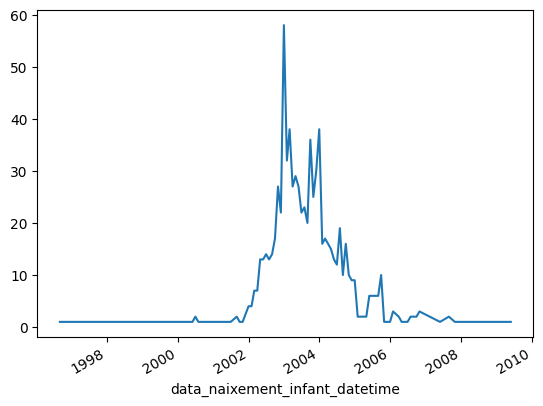

In [124]:
monthly_births.plot()

### Time zones

In [12]:
from datetime import datetime
import pytz
datetime_in_Madrid = datetime.now(pytz.timezone('Europe/Madrid'))

### Filter for time ranges

In [14]:
start = datetime.strptime('01/01/2001', '%d/%m/%Y')
end = datetime.strptime('02/01/2001', '%d/%m/%Y')

results_df_range = results_df[results_df.data_naixement_infant_datetime < end]
results_df_range = results_df_range[results_df_range.data_naixement_infant_datetime>=start]
results_df_range.head(2)

,id_infant_jove,data_entrada_sistema,any_entrada_sistema,mes_entrada_sistema,servei_territorial_gestio,data_naixement_infant,sexe_infant,origen_infant,data_naixement_infant_datetime
448,88674,2016-03-02T00:00:00.000,2016,03Març,Barcelona ciutat,2001-01-01T00:00:00.000,Nois,Marroc,2001-01-01
812,94896,2016-10-11T00:00:00.000,2016,10Octubre,Àrea Metropolitana BCN,2001-01-01T00:00:00.000,Noies,Països Subsharians,2001-01-01


### Filter for daytimes

If any of you has not only the days but actually the daytimes, they could filter for certain times of the day like this:

    results_df_with_daytimes.set_index("daytimes").between_time("00:05", "00:10")

# Fitting Time Series<a class="anchor" id=3></a>

In [154]:
x = monthly_births.index.map(pd.Timestamp.toordinal)  # Convert to days since epoch
y = monthly_births

#### Fitting to polynomial

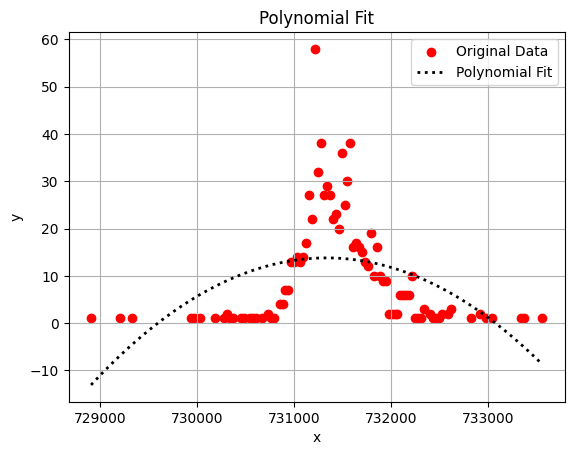

In [155]:
# Fit a polynomial of degree
z = np.polyfit(x, y, 2)

# Generate the polynomial function
p = np.poly1d(z)

# Generate x values for the fitted curve
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = p(x_fit)

# Plot the original data points
plt.scatter(x, y, color='red', label='Original Data')

# Plot the polynomial fit
plt.plot(x_fit, y_fit, color='black', linestyle=':', linewidth=2, label='Polynomial Fit')

# Add labels, legend, and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Fit')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Fitted parameters: a=30.919758834354848, b=731384.5513790065, c=302.2003341441114


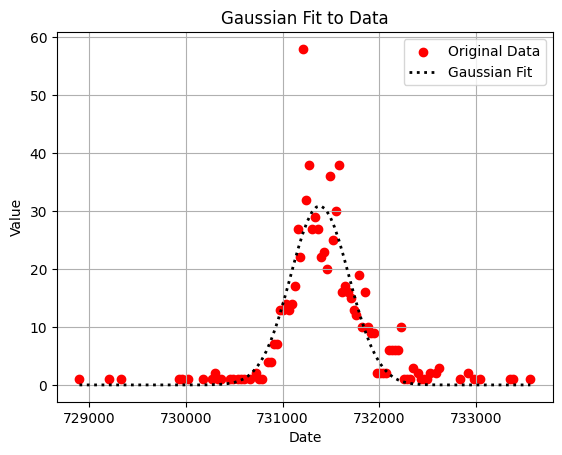

In [146]:
# Define a Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b)**2) / (2 * c**2))

x = monthly_births.index.map(pd.Timestamp.toordinal)  # Convert to days since epoch
y = monthly_births

# Initial parameter guesses: amplitude, mean, std deviation
initial_guess = [max(y), np.mean(x), np.std(x)]

# Fit the Gaussian curve to the data
params, covariance = curve_fit(gaussian, x, y, p0=initial_guess)

# Extract fitted parameters
a, b, c = params
print(f"Fitted parameters: a={a}, b={b}, c={c}")

# Generate x values for plotting the Gaussian fit
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = gaussian(x_fit, a, b, c)

# Plot the original data and the Gaussian fit
plt.scatter(x, y, color='red', label='Original Data')
plt.plot(x_fit, y_fit, color='black', linestyle=':', linewidth=2, label='Gaussian Fit')

# Add labels, legend, and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Gaussian Fit to Data')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

#### Fitting to gaussian

#### Fitting Gaussian

Fitted parameters: a=30.91975883582934, b=731384.5513789499, c=302.2003341148064


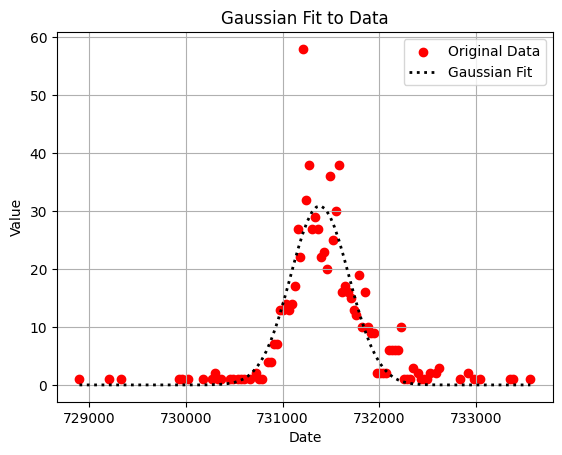

In [153]:
# Define a Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b)**2) / (2 * c**2))

# Initial parameter guesses: amplitude, mean, std deviation
initial_guess = [max(y), np.mean(x), np.std(x)]

# Fit the Gaussian curve to the data
params, covariance = curve_fit(gaussian, x, y, p0=initial_guess)

# Extract fitted parameters
a, b, c = params
print(f"Fitted parameters: a={a}, b={b}, c={c}")

# Generate x values for plotting the Gaussian fit
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = gaussian(x_fit, a, b, c)


# Plot the original data and the Gaussian fit
plt.scatter(x, y, color='red', label='Original Data')
plt.plot(x_fit, y_fit, color='black', linestyle=':', linewidth=2,  label='Gaussian Fit')

# Add labels, legend, and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Gaussian Fit to Data')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()